# Data augmentation on the mnist roman dataset for Data-Centric competition

## Refer to https://worksheets.codalab.org/worksheets/0x7a8721f11e61436e93ac8f76da83f0e6

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import json
import sys

import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.5.0


In [3]:
data_dir = 'label_book'

In [4]:
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.png')))
print(f'The foleder {data_dir} contains {image_count} pictures of roman numbers')

The foleder label_book contains 52 pictures of roman numbers


Let's visualize one roman number as example.

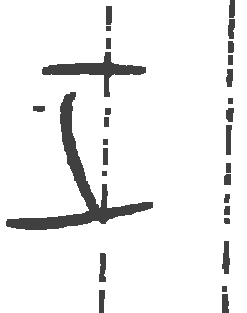

In [5]:
roman_i = list(data_dir.glob('i/*'))
PIL.Image.open(str(roman_i[0]))

Let's ingest the roman numbers by image_dataset_from_directory. The labels will be inferred by the 'class_names' parameter.

In [6]:
roman_numbers = "label_book"

batch_size = 8
tf.random.set_seed(123)

In [7]:
numbers_ds = tf.keras.preprocessing.image_dataset_from_directory(
    roman_numbers,
    labels="inferred",
    label_mode="categorical",
    class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
    shuffle=True,
    seed=123,
    batch_size=batch_size,
    image_size=(32, 32),
)

Found 52 files belonging to 10 classes.


In [8]:
class_names = numbers_ds.class_names
print(f"The class names are {class_names}")

The class names are ['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x']


In [9]:
for image_batch, labels_batch in numbers_ds:
    print("Batch shape", image_batch.shape)
    print("Labels shape", labels_batch.shape)
    break

numbers_of_batches = numbers_ds.cardinality().numpy()
print("Number of batches:", numbers_of_batches)


Batch shape (8, 32, 32, 3)
Labels shape (8, 10)
Number of batches: 7


## Visualize the data

Here are the first 8 images from the dataset.

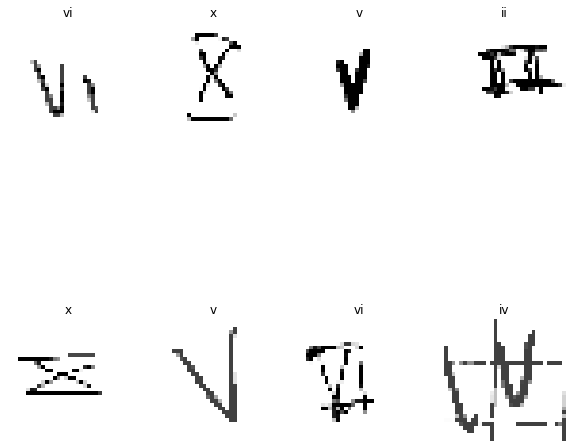

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in numbers_ds.take(1):
    for i in range(images.shape[0]):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[list(labels[i]).index(1)])
        plt.axis("off")

## Data augmentation

Now all the images have been loaded. We are ready to make some kind of data augmentation.\
Please refer to the following tutorial https://www.tensorflow.org/tutorials/images/data_augmentation.

### Horizontal flip

I    -->  I\
II   -->  II\
III  --> III\
IV   --> VI\
V    --> V\
VI   --> IV\
VII  --> IIV (not valid)\
VIII --> IIIV (not valid)\
IX   --> XI (not valid)\
X    --> X

In [11]:
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

In [12]:
data_horizontal_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
])

In [15]:
# if class_names[list(labels[i])] == 'x'
horizontal_exceptions = ['vii', 'viii', 'ix']
numbers_horizontal_ds = numbers_ds.map(lambda x, y: (data_horizontal_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

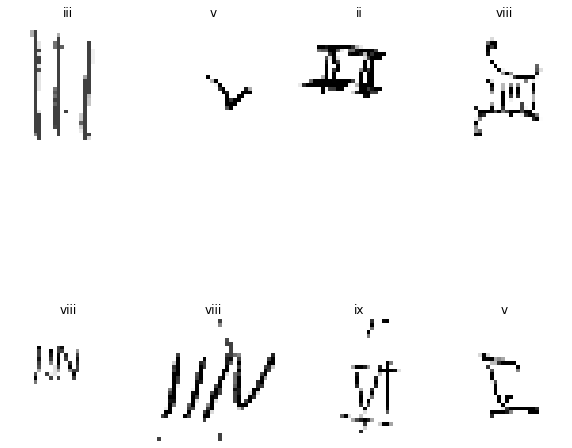

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in numbers_horizontal_ds.take(1):
    #print(images.shape)
    for i in range(images.shape[0]):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[list(labels[i]).index(1)])
        plt.axis("off")

### Vertical flip

I    -->  I\
II   -->  II\
III  --> III\
IV   --> not valid\
V    --> not valid\
VI   --> not valid\
VII  --> not valid\
VIII --> not valid\
IX   --> IX\
X    --> X

In [18]:
data_vertical_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("vertical"),
])

In [19]:
verticall_exceptions = ['vii', 'viii', 'ix']
numbers_vertical_ds = numbers_ds.map(lambda x, y: (data_vertical_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

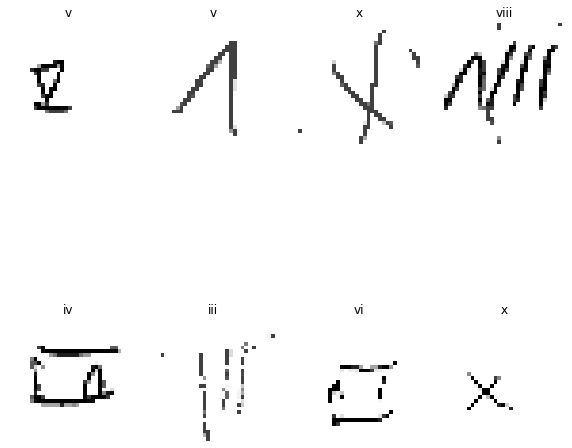

In [20]:
plt.figure(figsize=(10, 10))
for images, labels in numbers_vertical_ds.take(1):
    #print(images.shape)
    for i in range(images.shape[0]):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[list(labels[i]).index(1)])
        plt.axis("off")

Not let's save only the images that corresponds to a meangiful roman numbers.